In [1]:
import numpy as np
import os
import pickle


import tensorflow as tf

import keras
from keras import layers
from keras.layers import Input, merge,Add,Average, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import model_from_json
from keras.utils import np_utils 
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils.training_utils import multi_gpu_model
from keras.utils import to_categorical
from keras import optimizers
from keras import regularizers

os.environ["PATH"] += os.pathsep + '~/anaconda3/lib/bin/pydot/'
os.environ["PATH"] += os.pathsep + '~/anaconda3/lib/bin/graphviz/'
import pydot
import scipy.misc
from matplotlib.pyplot import imshow
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using CNTK backend
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\keras\backend\cntk_backend.py:21: UserWarning: CNTK backend warning: GPU is not detected. CNTK's CPU version is not fully optimized,please run with GPU to get better performance.
  'CNTK backend warning: GPU is not detected. '


ModuleNotFoundError: No module named 'pydot'

In [ ]:
#LIsting available devices 

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [3]:
#Using AWS p2 instance with 1 gpu and 4 cpus 
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [6]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

#One hot encoding Y 
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print('Shape of X train: ',X_train.shape)
print('Shape of Y train: ',Y_train.shape)
print('Shape of X test: ',X_test.shape)
print('Shape of Y test: ',Y_test.shape)

Shape of X test:  (10000, 32, 32, 3)
Shape of Y test:  (10000, 10)


In [5]:
def join_layer(*signals_to_join,ldrop_prob=0):
    
    '''
    Input: 
            signals_to_join - Variable number of tensor signals to join at
                              layer depending on where in the network the 
                              join layer function is called and whether
                              dropout is enabled.For example, the number 
                              of signals to join at the end of a fractal
                              block with number of columns = 4 would be 4 
                              (without global/local dropout)
          
            ldrop_prob - local dropout probability - 15% for all signals 
                         at every join layer. We need to make sure at least
                         one signal survives in each join layer 
            
                              
    Output:
            The merged output signal after implementing local dropout
    
    '''    
   
    #Packing all signals in a list 

    list_of_signals = [signal for signal in signals_to_join]

    #Probability that an input signal is not dropped 
    lkeep_prob = 1-ldrop_prob 
    
    #Making a list of signals to be added by incorporating local 
    #drop path while also ensuring that at least one path survives
    rand = np.random.uniform(low=0.0, high=1.0)
    signals_survived = [signal for signal in signals_to_join if rand<= lkeep_prob]
   
    #If all signals have been dropped 
    if len(signals_survived)==0:
        
        #To ensure that at least one path survives we randomly
        #select a single signal and pass it on to merge 
        rand_signal_index = np.random.randint(len(list_of_signals))
        
        #Using the randomly selected signal and making a list 
        #To pass it onto the keras method to average
        signals_survived = list_of_signals[rand_signal_index]
        return signals_survived
    
    #The paper implements the join layer by taking element wise average
    out = Average()(signals_survived)
    
    return out

## Fractal Block

In [6]:
def basic_conv(X_inp,f_number,f_size):
    '''
    Basic Convolutional layer
    '''
    
    X = Conv2D(filters = f_number, kernel_size = (f_size, f_size), strides = (1,1), padding = 'same',kernel_initializer ='he_normal',kernel_regularizer=l2(1e-4))(X_inp)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    return X

def fractal_block(Z,f_number,f_size):
    
    '''
    Input:
            Z - input feature vector 
            C - number of columns in a fractal block 
            filter_size - size of the kernel for convolution in a block
            filter_number - number of filter channels for all convolutions in a block\
           
      
    Output:
            A - Output of fractal block 
    '''
    #A fractal block with 4 columns 
    X_keep1 = Z
    X_keep2 = Z
    X_keeplast = Z
    A = basic_conv(Z,f_number,f_size)
    A = basic_conv(A,f_number,f_size)
    X_keep1 = basic_conv(X_keep1,f_number,f_size)
    A = join_layer(X_keep1,A)
    X_keep3 = A
    A = basic_conv(A,f_number,f_size)
    A = basic_conv(A,f_number,f_size)
    X_keep3 = basic_conv(X_keep3,f_number,f_size)
    X_keep2 = basic_conv(X_keep2,f_number,f_size)
    J = join_layer(A,X_keep3,X_keep2)

    X_keep1 = J
    X_keep2 = J
    A = basic_conv(J,f_number,f_size)
    A = basic_conv(A,f_number,f_size)
    X_keep1 = basic_conv(X_keep1,f_number,f_size)
    A = join_layer(X_keep1,A)
    X_keep3 = A
    A = basic_conv(A,f_number,f_size)
    A = basic_conv(A,f_number,f_size)
    X_keep3 = basic_conv(X_keep3,f_number,f_size)
    X_keep2 = basic_conv(X_keep2,f_number,f_size)
    X_keeplast = basic_conv(X_keeplast,f_number,f_size)
    A = join_layer(A,X_keep3,X_keep2,X_keeplast)

    return A

In [7]:
def FractalNet(input_shape = (32, 32, 3), classes = 10): 
    
    '''
    Input:
            input_shape - the shape of the input image 
            classes - number of classes 
            B - number of blocks in the fractal net 

    Output:
            A keras model instance 
            
    '''
    
    #Defining input shape and converting into a keras input tensor
    X_input = Input(input_shape)
    X = X_input
    
    #Block 1 
    X = fractal_block(X,16,3)
    X = MaxPooling2D(pool_size = (2,2), name='max_pool1')(X)
    
    #Block 2 
    X = fractal_block(X,32,3)
    X=MaxPooling2D(pool_size = (2,2), name='max_pool2')(X)
    
    #Block 3 
    X = fractal_block(X,64,3)
    X=MaxPooling2D(pool_size = (2,2), name='max_pool3')(X)
    
#     #Block 4 
#     X = fractal_block(X,512,3)
#     X=MaxPooling2D(pool_size = (2,2), name='max_pool4')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer ='he_normal')(X)
    
    model = Model(inputs = X_input, outputs = X, name='FractalNet')
    return model

In [8]:
model = FractalNet(input_shape = (32, 32, 3), classes = 10)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
plot_model(model, to_file='fractalnet_model.png', show_shapes=True, show_layer_names=False)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
class MyCallbackFunction(keras.callbacks.Callback):

    def on_train_begin(self, logs={} ):
        #Learning rate schedule
        #Changed after 80,120,160,180 epochs 
        
        self.k = 0
        
        #Keeping track of number of epochs 
        self.epoch_n = 0 
        
        #Learning rates list
        self.lrs_in_epoch = [1e-4,1e-5,1e-6,1e-7]
        
        #History of losses and accuracies 
        self.loss = []
        self.val_acc =[]
        self.train_acc = []

        #monitoring improvement of validation accuracy 
        #Setting initial val acc to negative infinity 
        self.val_prev = -float("inf")
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs):
        
        #Storing validation and training accuracies of the epoch
        self.val_acc.append(logs.get('val_acc'))
        self.train_acc.append(logs.get('acc'))

        #Incrementing number of epochs 
        self.epoch_n +=1
        
        #Saving model if val acc improves compared to best previous epoch
        if logs.get('val_acc') > self.val_prev: 
            print('Validation accuracy improved! Saving model. \n')
        
            #Saving model 
            json_string = model.to_json()
            with open('fractalnet_models/model_epoch'+str(self.epoch_n)+'_json.pkl', 'wb') as m:
                pickle.dump(json_string, m)
            model.save_weights('fractalnet_models/model_epoch'+str(self.epoch_n)+'_weights.h5')
            
            #Saving current better val acc to compare with next epoch's val acc
            self.val_prev = logs.get('val_acc')
            
        else: 
            print('Validation accuracy did not improve. Moving on. \n')
        
        #Printing learning rate 
        LR = K.get_value(self.model.optimizer.lr)
        print('Current learning rate: ',LR )

            
        #Adjusting learning rate     
        if self.epoch_n == 80 or self.epoch_n == 120 or self.epoch_n == 160 or self.epoch_n == 180:
            K.set_value(self.model.optimizer.lr,self.lrs_in_epoch[self.k])
            self.k+=1
    

#Main 

#Creating an instance of the callback function
history_cb = MyCallbackFunction()

Real time data augmentation enabled.

Initial Learning rate:  0.001
Epoch 1/200
1563/1562 [==============================] - 152s 97ms/step - loss: 1.5868 - acc: 0.5168 - val_loss: 1.2121 - val_acc: 0.6622
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 2/200
1563/1562 [==============================] - 145s 93ms/step - loss: 1.1150 - acc: 0.6895 - val_loss: 1.0053 - val_acc: 0.7310
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 3/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.9511 - acc: 0.7425 - val_loss: 0.8636 - val_acc: 0.7778
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 4/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.8611 - acc: 0.7727 - val_loss: 0.8033 - val_acc: 0.7972
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 5/200
1563/1562 [==============================] - 145s 93ms/step - lo

Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 39/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.5227 - acc: 0.8972 - val_loss: 0.6005 - val_acc: 0.8787
Validation accuracy improved! Saving model. 

Current learning rate:  0.001
Epoch 40/200
1563/1562 [==============================] - 146s 93ms/step - loss: 0.5157 - acc: 0.8988 - val_loss: 0.6082 - val_acc: 0.8750
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 41/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.5155 - acc: 0.8990 - val_loss: 0.6142 - val_acc: 0.8694
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 42/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.5109 - acc: 0.9014 - val_loss: 0.5915 - val_acc: 0.8748
Validation accuracy did not improve. Moving on. 

Current learning rate:  0.001
Epoch 43/200
1563/1562 [========================

Validation accuracy improved! Saving model. 

Current learning rate:  1e-04
Epoch 114/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.1977 - acc: 0.9779 - val_loss: 0.4407 - val_acc: 0.9158
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-04
Epoch 115/200
1563/1562 [==============================] - 146s 93ms/step - loss: 0.1948 - acc: 0.9788 - val_loss: 0.4461 - val_acc: 0.9141
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-04
Epoch 116/200
1563/1562 [==============================] - 147s 94ms/step - loss: 0.1937 - acc: 0.9791 - val_loss: 0.4377 - val_acc: 0.9137
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-04
Epoch 117/200
1563/1562 [==============================] - 146s 94ms/step - loss: 0.1905 - acc: 0.9794 - val_loss: 0.4406 - val_acc: 0.9152
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-04
Epoch 118/200
1563/1562 [===================

1563/1562 [==============================] - 146s 93ms/step - loss: 0.1608 - acc: 0.9876 - val_loss: 0.4315 - val_acc: 0.9188
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 152/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.1590 - acc: 0.9881 - val_loss: 0.4309 - val_acc: 0.9186
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 153/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.1597 - acc: 0.9874 - val_loss: 0.4323 - val_acc: 0.9183
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 154/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.1603 - acc: 0.9870 - val_loss: 0.4333 - val_acc: 0.9186
Validation accuracy did not improve. Moving on. 

Current learning rate:  1e-05
Epoch 155/200
1563/1562 [==============================] - 145s 93ms/step - loss: 0.1579 - acc: 0.9884 - val_loss: 0.4303 - val_acc: 0

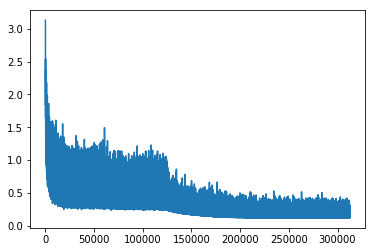

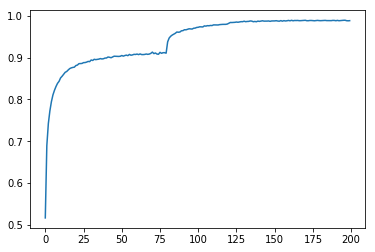

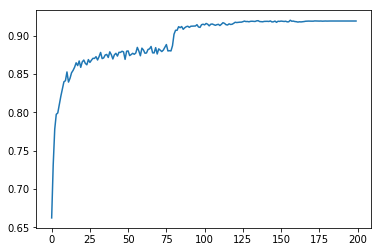

In [10]:
#Initial learning rate and optimizer
initial_rate = 0.001
opt = optimizers.Adam(lr=initial_rate)

#Compiling model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


#Data generator for training data  
#No data generator is used for testing data
data_generator = ImageDataGenerator(
                featurewise_center=False,
                samplewise_center = False,
                featurewise_std_normalization = False,
                samplewise_std_normalization=False,
                zca_whitening= False,
                rotation_range=0,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                vertical_flip=False,
                )

print('Real time data augmentation enabled.\n')
print('Initial Learning rate: ',initial_rate)

#Fitting model
model.fit_generator(data_generator.flow(X_train, Y_train, batch_size=32),
                    validation_data = (X_test, Y_test),
                    epochs = 200, 
                    steps_per_epoch = data_generator.flow(X_train,Y_train,batch_size=32).n/32,
                    callbacks = [history_cb])


#Model evaluation 
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

#Plotting loss and accuracies
plt.plot(history_cb.loss)
plt.show()

plt.plot(history_cb.train_acc)
plt.show()

plt.plot(history_cb.val_acc)
plt.show()

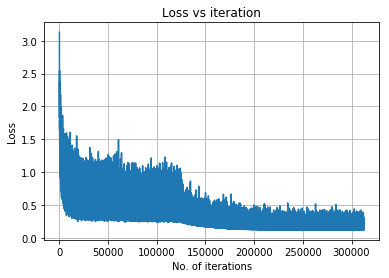

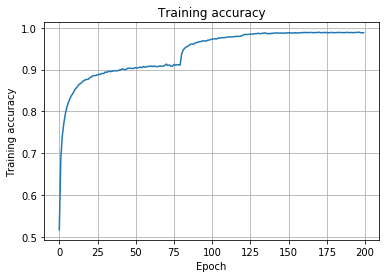

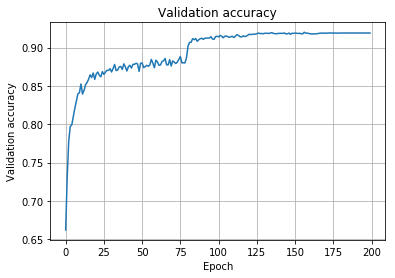

In [11]:
plt.plot(history_cb.loss)
plt.grid()
plt.title('Loss vs iteration')
plt.xlabel('No. of iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(history_cb.train_acc)
plt.grid()
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.show()

plt.plot(history_cb.val_acc)
plt.grid()
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.show()

In [13]:
#Saving histories 
with open('fractalnet_models/loss.pkl', 'wb') as m:
                pickle.dump(history_cb.loss, m)
        
with open('fractalnet_models/valacc.pkl', 'wb') as mo:
        pickle.dump(history_cb.val_acc, mo)
        
with open('fractalnet_models/trainacc.pkl', 'wb') as mu:
                pickle.dump(history_cb.train_acc, mu)

In [3]:
#Loading best fractalnet model 
json_string = pickle.load( open( "model_epoch157_json.pkl", "rb" ) )
model = model_from_json(json_string)
model.load_weights('model_epoch157_weights.h5')

In [7]:
"""
Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 

"""
import sklearn
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.92 0.   0.02 0.01 0.   0.   0.   0.01 0.03 0.02]
 [0.   0.95 0.   0.   0.   0.   0.   0.   0.01 0.04]
 [0.02 0.   0.89 0.02 0.03 0.01 0.02 0.01 0.01 0.  ]
 [0.01 0.   0.02 0.84 0.01 0.05 0.03 0.01 0.01 0.01]
 [0.01 0.   0.01 0.01 0.93 0.01 0.   0.02 0.   0.  ]
 [0.   0.   0.02 0.07 0.02 0.86 0.01 0.01 0.   0.  ]
 [0.01 0.   0.01 0.03 0.01 0.01 0.94 0.   0.   0.01]
 [0.01 0.   0.01 0.01 0.01 0.01 0.   0.95 0.   0.  ]
 [0.02 0.01 0.   0.   0.   0.   0.   0.   0.96 0.01]
 [0.01 0.03 0.   0.   0.   0.   0.   0.   0.01 0.96]]


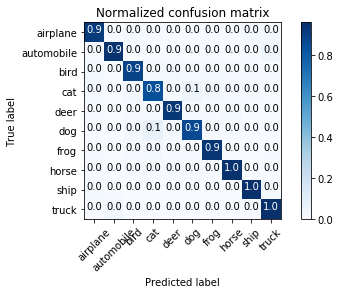

 Testing accuracy: 
0.9199


In [8]:
#Prediction test set 
p = model.predict(X_test)
#Converting from one hot back to integers
y_pred = [np.where(r==np.max(r))[0][0] for r in p]

#Ground truth
a = Y_test
#Converting from one hot back to integers
y_true = [np.where(r==1)[0][0] for r in a ]

#Caulculating confusion matrix 
cnf_matrix = confusion_matrix(y_true,y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'],normalize=True,
                      title='Normalized confusion matrix')

plt.show()


print(' Testing accuracy: ')
pr = model.predict(X_test)
ypred = [np.where(r==np.max(r))[0][0] for r in pr]
good = [1 for i in range(0,len(ypred)) if y_true[i]==ypred[i]]
accuracy = len(good)/len(ypred)
print(accuracy)